In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [190]:
class Thermostat:
    def __init__(self, init_state_on=False, T_setpoint=21, T_band=1.0, noise_sigma=0.2, resolution=0.5):
        self.is_on = init_state_on
        self.T_setpoint = T_setpoint
        self.T_band = T_band
        self.noise_sigma = noise_sigma
        self.resolution = resolution
        
    def update_state(self, T_real):
        T_measured = np.round((T_real + self.noise_sigma * np.random.randn(1)[0])/self.resolution)*self.resolution
        toggled = False
        turned_on = False
        turned_off = False
        # Decide whether to turn off
        if(self.is_on):
            if(T_measured > (self.T_setpoint + self.T_band/2)):
                turned_off = True
                self.is_on = False
        # Decide whether to turn on
        else:
            if(T_measured < (self.T_setpoint - self.T_band/2)):
                turned_on = True
                self.is_on = True
                
        #print('T_real: {0}\tT_measured: {1}\tToggled: {2}\tState: {3}'.format(T_real, T_measured, toggled, self.is_on))
        return T_measured, turned_on, turned_off
        
def CtoF(degrees_c):
    return degrees_c * 9.0/5.0 + 32.0

def HeatExchange(k, T_outside, T_inside, energy_inside):
    '''
    How much energy to transfer given the temperature and energy inside the house. 
    Positive means energy coming into house. 
    '''
    #print('k: ', k, 'energy_inside: ', energy_inside, 'T_outside: ', T_outside, 'T_inside: ', T_inside)
    return k*energy_inside*(T_outside - T_inside)


In [247]:
class Simulation:
    def __init__(self, days=10, add_energy_randomly_every_day=False, model_nonlin_heat=False):
        # Calculate how long the simulation will run
        self.days = days
        self.seconds_per_hour = 60 * 60
        self.seconds_per_day = 24 * self.seconds_per_hour
        self.time_max_s = self.days * self.seconds_per_day
        self.T_init = 21
        self.T_setpoint=21
        self.model_nonlin_heat=model_nonlin_heat
        
        # Calculate house specs
        # How much power the furnace is capable of putting into the house in Watts
        self.furnace_power = 100000 / 60 / 60 / 3.41
        # How much power the house leaks to outside in Watts for the first second (or forever if nonlin is disabled)
        self.init_house_power_leakage = 18000 / 60 / 60 / 3.41
        # Volume of the house in m^3 (exagerated to compensate for hard things)
        self.volume_of_house = 6500
        # In kg / m^3
        self.air_density = 1.29
        self.house_air_mass =  self.volume_of_house * self.air_density
        # In kJ / (kg * deg K)
        self.air_specific_heat = 1.005
        # Kelvin offset
        self.kelvin_offset = 273.15
        # Outside temperature (in degrees celcius)
        self.T_outside = 0
        self.init_energy_house = (self.T_init + self.kelvin_offset) * self.air_specific_heat * self.house_air_mass
        # Thermal conductivity of house CALCULATED TO BE EQUIVALENT OF INIT_HOUSE_POWER_LEAKAGE. Might not work.
        self.thermal_conductivity = -1.0 * self.init_house_power_leakage / (self.init_energy_house * (self.T_outside - self.calc_T_real(self.init_energy_house)))
        # The excess energy in a pot of water heated to 60C (140F)
        self.extra_energy_to_add = 270 / 3.4
        # Whether or not to add energy at a random time of the day
        self.add_energy_randomly_every_day = add_energy_randomly_every_day        
        
        # Dict for tracking metrics
        self.stat_track = {}
    
    def calc_T_real(self, home_energy):
        return home_energy / (self.air_specific_heat * self.house_air_mass) - self.kelvin_offset
    
    def stats(self, key):
        return self.stat_track[key]
    
    def dstats(self, key, di=0, de=1):
        return self.stat_track[key][di*self.seconds_per_day:de*self.seconds_per_day]

    def hstats(self, key, hi=0, he=1):
        return self.stat_track[key][hi*self.seconds_per_hour:he*self.seconds_per_hour]

    def run_simulation(self, days=10, enable_thermostat=True):
        
        print('Furnace power: {0}\tHouse Power Leakage: {1}'.format(self.furnace_power, self.init_house_power_leakage))
        thermostat = Thermostat(T_setpoint = self.T_setpoint)
        
        home_energy = self.init_energy_house
        T_real = self.calc_T_real(home_energy)
        T_measured = thermostat.update_state(T_real)
        self.stat_track = {'T_real': [], 'T_measured': [], 'Home_energy': [], 'Thermostat_state': [], 
                           'Thermostat_t_on': [], 'Thermostat_t_off': [], 'Furnace_energy_sum': []}
        
        when_to_add_energy = None
        
        for time in range(self.time_max_s):
            if((time % self.seconds_per_day == 0) and self.add_energy_randomly_every_day):
                when_to_add_energy = int(np.random.rand(1)[0] * self.seconds_per_day)

            self.stat_track['T_real'] += [T_real]
            self.stat_track['T_measured'] += [T_measured]
            self.stat_track['Home_energy'] += [home_energy]
            self.stat_track['Thermostat_state'] += [thermostat.is_on]

            if(thermostat.is_on and enable_thermostat):
                home_energy += self.furnace_power
                self.stat_track['Furnace_energy_sum'] += [self.furnace_power if(time == 0) else self.furnace_power + self.stat_track['Furnace_energy_sum'][-1]]
            else:
                self.stat_track['Furnace_energy_sum'] += [0 if(time == 0) else 0 + self.stat_track['Furnace_energy_sum'][-1]]

            if(self.add_energy_randomly_every_day and (((time - when_to_add_energy) % self.seconds_per_day) == 0)):
                home_energy += self.extra_energy_to_add
                print('Adding energy to system for no good reason!')
                
            # Remove energy from the house due to loss to outside
            if(self.model_nonlin_heat):
                home_energy += HeatExchange(k=self.thermal_conductivity, T_outside=self.T_outside, T_inside=T_real, energy_inside=home_energy)

            else:
                home_energy -= self.init_house_power_leakage
            T_real = home_energy / (self.air_specific_heat * self.house_air_mass) - self.kelvin_offset
            T_measured, turned_on, turned_off = thermostat.update_state(T_real)
            if(turned_on):
                self.stat_track['Thermostat_t_on'] += [time]
            if(turned_off):
                self.stat_track['Thermostat_t_off'] += [time]

        # Turn all lists to arrays
        for key in self.stat_track.keys():
            self.stat_track[key] = np.array(self.stat_track[key])
        print('Used {0} Watts from furnace.'.format(self.stat_track['Furnace_energy_sum'][-1]))
        return self.stat_track

# Example usage:
sim = Simulation(days=2, add_energy_randomly_every_day=True, model_nonlin_heat=True)
results = sim.run_simulation()

Furnace power: 8.145975887911371	House Power Leakage: 1.466275659824047
Adding energy to system for no good reason!
Adding energy to system for no good reason!
Used 252403.06288704305 Watts from furnace.


/tmp/ipykernel_4274/3527595968.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.stat_track[key] = np.array(self.stat_track[key])


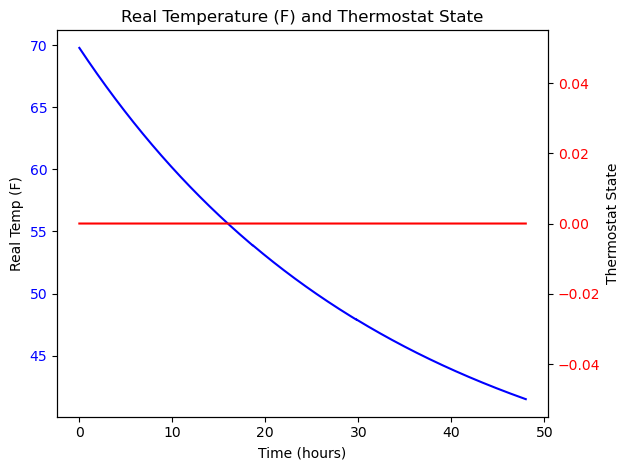

In [239]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Real Temp (F)')
time_hours = np.arange(len(sim.stats('T_real')))/sim.seconds_per_hour
ax1.plot(time_hours, CtoF(sim.stats('T_real')), label='T_real', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Thermostat State')  # we already handled the x-label with ax1
ax2.plot(time_hours, sim.stats('Thermostat_state'), label='Thermostat_state', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Real Temperature (F) and Thermostat State')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
days_to_run = 10000
sim1 = Simulation(days=days_to_run, add_energy_randomly_every_day=False, model_nonlin_heat=True)
sim2 = Simulation(days=days_to_run, add_energy_randomly_every_day=True, model_nonlin_heat=True)
sim1.run_simulation()
sim2.run_simulation()

Furnace power: 8.145975887911371	House Power Leakage: 1.466275659824047


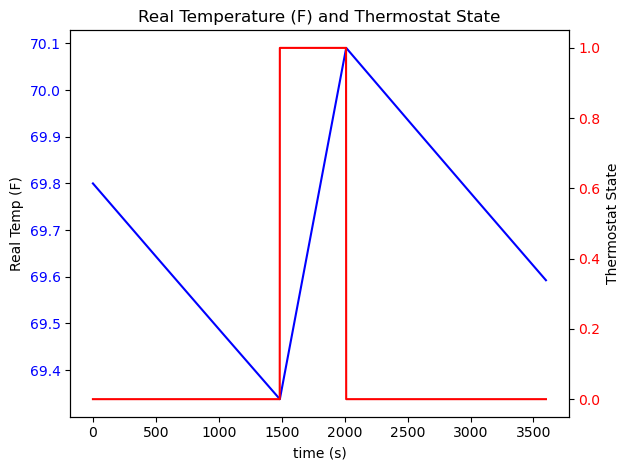

In [271]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Real Temp (F)')
ax1.plot(CtoF(sim1.hstats('T_real')), label='T_real', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Thermostat State')  # we already handled the x-label with ax1
ax2.plot(sim1.hstats('Thermostat_state'), label='Thermostat_state', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Real Temperature (F) and Thermostat State')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
(sim2.stat_track['Furnace_energy_sum'][-1] - sim1.stat_track['Furnace_energy_sum'][-1]) / (270/3.4) 

-11.078527207532899

126686249.59063262

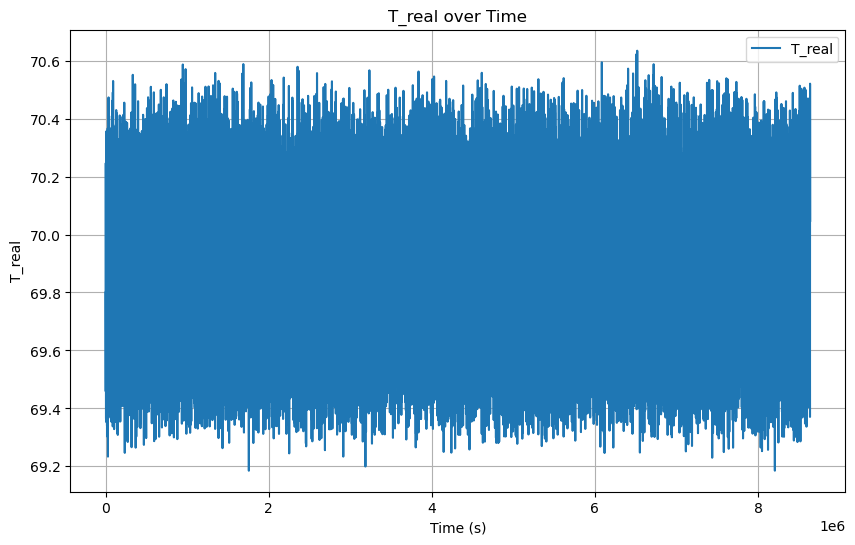

In [257]:
plt.figure(figsize=(10, 6))  # Define the size of the plot
    
stat = 'T_real'
# Plotting
plt.plot(CtoF(sim1.stat_track[stat]), label=stat)
#plt.plot(stat_track2[stat], label=stat)

# Adding labels and legend
plt.xlabel('Time (s)')
plt.ylabel(stat)
plt.title('{0} over Time'.format(stat))
plt.legend()

# Display the plot
plt.grid(True) # Enable grid
plt.show()


In [ ]:
fig, ax1 = plt.subplots()
stat = 'Furnace_energy_sum'

# Plotting
time_arr = np.arange(sim1.seconds_per_day * (days_to_run)) + 1
plt.plot(time_arr, sim1.dstats(stat, di=0, de=days_to_run)/time_arr, label=stat)
plt.plot(time_arr, sim2.dstats(stat, di=0, de=days_to_run)/time_arr, label=stat)

ypbot = np.percentile(sim1.dstats(stat, di=0, de=days_to_run)/time_arr, 1)
yptop = np.percentile(sim1.dstats(stat, di=0, de=days_to_run)/time_arr, 99)
ypad = 0.2*(yptop - ypbot)
ymin = ypbot - ypad
ymax = yptop + ypad

# Adding labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Average Furnace Power (W)')
plt.title('Average Furnace Power over Time')
ax1.set_ylim([ymin, ymax])


# Display the plot
plt.grid(True) # Enable grid
plt.show()


In [260]:
print(sim2.stat_track['Furnace_energy_sum'][-1])
print(sim1.stat_track['Furnace_energy_sum'][-1])

12662748.452098954
12669778.429290105


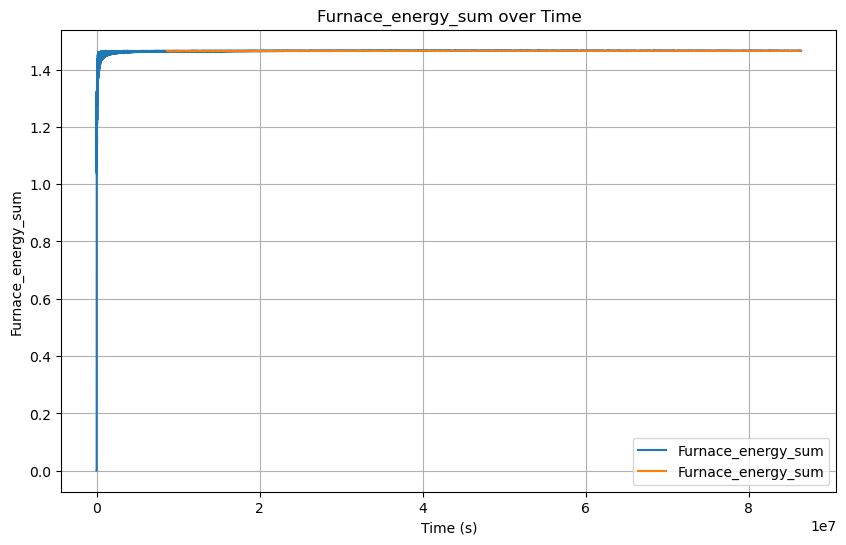

In [151]:
plt.figure(figsize=(10, 6))  # Define the size of the plot
    
stat = 'Furnace_energy_sum'

#ss = 10000000
n_samples = len(sim2.stat_track[stat])
time_arr = np.arange(sim1.seconds_per_day * (days_to_run)) + 1000
plt.plot(time_arr, sim2.stat_track[stat]/time_arr, label=stat)
plt.plot(time_arr[n_samples//10::100000], sim2.stat_track[stat][n_samples//10::100000]/time_arr[n_samples//10::100000], label=stat)
#plt.plot(time_arr[n_samples//2::100000], sim2.stat_track[stat][n_samples//2::100000], label=stat)


# Adding labels and legend
plt.xlabel('Time (s)')
plt.ylabel(stat)
plt.title('{0} over Time'.format(stat))
plt.legend()

# Display the plot
plt.grid(True) # Enable grid
plt.show()


In [116]:
(sim2.stat_track['Furnace_energy_sum'][-1] - sim1.stat_track['Furnace_energy_sum'][-1])/days_to_run

-1584.881068725586

In [118]:
print(sim2.stat_track['Furnace_energy_sum'][-1]/(days_to_run*sim1.seconds_per_day))
print(sim1.stat_track['Furnace_energy_sum'][-1]/(days_to_run*sim1.seconds_per_day))

1.4653895963585817
1.466306772902983


In [ ]:
np.arange(10)[-3:]

In [ ]:
plt.figure(figsize=(10, 6))  # Define the size of the plot
    
stat = 'Furnace_energy_sum'
# Plotting
time_arr = np.arange(seconds_per_day * 1000)
plt.plot(time_arr[-30000000:], stat_track1[stat][-30000000:]/time_arr[-30000000:], label=stat)
plt.plot(time_arr[-30000000:], stat_track2[stat][-30000000:]/time_arr[-30000000:], label=stat)

# Adding labels and legend
plt.xlabel('Time (s)')
plt.ylabel(stat)
plt.title('{0} over Time'.format(stat))
plt.legend()

# Display the plot
plt.grid(True) # Enable grid
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))  # Define the size of the plot
    
stat = 'Furnace_energy_sum'
# Plotting
time_arr = np.arange(seconds_per_day * 1000)
plt.plot(time_arr[1000000::100], stat_track1[stat][1000000::100]/time_arr[1000000::100], label=stat)
plt.plot(time_arr[1000000::100], stat_track2[stat][1000000::100]/time_arr[1000000::100], label=stat)

# Adding labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Running Average Furnace Power')
plt.title('Average Furnace Power Over Time')
plt.legend()

# Display the plot
plt.grid(True) # Enable grid
plt.show()


In [ ]:
np.arange(100)[10::4]